In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import json
import re
import nltk
import tkinter as tk
from tkinter import ttk
import ast

In [2]:
movies_df = pd.read_csv('../../edit_data/Lee/cleaned_data/movies_main.csv')  

In [3]:
movies_df.columns

Index(['Id', 'Original_Title', 'Original_Language', 'Spoken_Languages',
       'Budget', 'Revenue', 'Runtime', 'Release_Date', 'Production_Companies',
       'Production_Countries', 'imdb_id', 'Popularity', 'Vote_Average',
       'Vote_Count', 'Belongs_To_Collection', 'Tagline', 'Overview', 'Genres',
       'Genres_Parse', 'Belongs_To_Collection_Parse', 'Spoken_Languages_Parse',
       'Production_Companies_Parse', 'Production_Countries_Parse',
       'Production_Countries_Code_Parse', 'Keywords', 'Keywords_parse',
       'Cast_parse', 'Director_parse'],
      dtype='object')

In [4]:
movies_df.head(2)

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,...,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,"['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,"['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']


In [6]:
# # Initialize the main window
# root = tk.Tk()
# root.title("Movie Recommender")

# # Define the function to show recommendations
# def show_recommendations():
#     genre = genre_input.get()
#     year = year_input.get()
#     rating = rating_input.get()
#     recommendations = recommend_movies(genre, year, rating)
#     result_var.set("\n".join(recommendations))

# # Simple recommendation function considering multiple inputs
# def recommend_movies(genre, year, rating):
#     filtered_movies = movies_df
    
#     if genre:
#         filtered_movies = filtered_movies[filtered_movies['genres'].str.contains(genre, case=False, na=False)]
#     if year:
#         filtered_movies = filtered_movies[filtered_movies['release_date'].str.contains(year, na=False)]
#     if rating:
#         filtered_movies = filtered_movies[filtered_movies['vote_average'] >= float(rating)]
    
#     top_movies = filtered_movies.head(10)['title'].tolist()
#     return top_movies

# # Add a label and entry for genre input
# ttk.Label(root, text="Enter your preferred genre:").grid(column=0, row=0, padx=10, pady=10)
# genre_input = ttk.Entry(root)
# genre_input.grid(column=1, row=0, padx=10, pady=10)

# # Add a label and entry for year input
# ttk.Label(root, text="Enter release year:").grid(column=0, row=1, padx=10, pady=10)
# year_input = ttk.Entry(root)
# year_input.grid(column=1, row=1, padx=10, pady=10)

# # Add a label and entry for rating input
# ttk.Label(root, text="Enter minimum rating:").grid(column=0, row=2, padx=10, pady=10)
# rating_input = ttk.Entry(root)
# rating_input.grid(column=1, row=2, padx=10, pady=10)

# # Add a button to trigger recommendation
# ttk.Button(root, text="Get Recommendations", command=show_recommendations).grid(column=0, row=3, columnspan=2, padx=10, pady=10)

# # Add a label to display the results
# result_var = tk.StringVar()
# ttk.Label(root, textvariable=result_var).grid(column=0, row=4, columnspan=2, padx=10, pady=10)

# # Run the application
# root.mainloop()


In [4]:
# Define a function to extract genres from a single row entry
def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)  # Convert string to list of dicts
        return [genre['name'] for genre in genres]
    except:
        return []

# Use the function to extract genres for the entire column
all_genres = set()
movies_df['genres'].dropna().apply(lambda x: all_genres.update(extract_genres(x)))

# Convert the set to a sorted list
all_genres = sorted(list(all_genres))

# Display all unique genres
print(all_genres)

['Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Romance', 'Science Fiction', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'The Cartel', 'Thriller', 'Vision View Entertainment', 'War', 'Western']


In [5]:
# Search for movies produced by "Carousel Productions"
carousel_movies = movies_df[movies_df['production_companies'].str.contains("Carousel Productions", case=False, na=False)]

# Display the titles of the movies
carousel_movie_titles = carousel_movies['title'].tolist()
carousel_movie_titles


['The Deadly Companions', 'The Incredible Burt Wonderstone']

In [18]:
# Extract unique genres from the dataset
def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [genre['name'] for genre in genres]
    except:
        return []

# Extract the release year from the release_date column
movies_df['Release_Year'] = pd.to_datetime(movies_df['Release_Date'], errors='coerce').dt.year

all_genres = set()
all_release_years = sorted(movies_df['Release_Year'].dropna().astype(int).unique(), reverse=True)

movies_df['Genres'].dropna().apply(lambda x: all_genres.update(extract_genres(x)))

all_genres = sorted(list(all_genres))

# Initialize the main window
root = tk.Tk()
root.title("Movie Recommender")

# Define the function to show recommendations
def show_recommendations():
    genre = genre_input.get()
    release_year = release_year_input.get()
    keywords = keyword_input.get()
    recommendations = recommend_movies(genre, release_year, keywords)
    result_var.set("\n".join(recommendations))

# Calculate match percentage based on genre, release year, and keywords
def calculate_match_percentage(row, genre, release_year, keywords):
    match_score = 0
    total_criteria = 3  # We have three criteria now: genre, release year, and keywords
    
    # Check genre match
    if genre and genre != "Any":
        if genre in extract_genres(row['Genres']):
            match_score += 1
    
    # Check release year match
    if release_year and release_year != "Any":
        if pd.notna(row['Release_Year']) and row['Release_Year'] == int(release_year):
            match_score += 1
            
    # Check keyword match
    if keywords:
        if pd.notna(row['Overview']) and keywords.lower() in row['Overview'].lower():
            match_score += 1
    
    # Calculate percentage
    return (match_score / total_criteria) * 100

# Recommendation function with percentage calculation
def recommend_movies(genre, release_year, keywords):
    filtered_movies = movies_df
    
    if genre and genre != "Any":
        filtered_movies = filtered_movies[filtered_movies['Genres'].str.contains(genre, case=False, na=False)]
    if release_year and release_year != "Any":
        filtered_movies = filtered_movies[filtered_movies['Release_Year'] == int(release_year)]
    if keywords:
        filtered_movies = filtered_movies[filtered_movies['Overview'].str.contains(keywords, case=False, na=False)]
    
    # Calculate match percentages
    filtered_movies['match_percentage'] = filtered_movies.apply(lambda row: calculate_match_percentage(row, genre, release_year, keywords), axis=1)
    
    # Sort by match percentage and limit to top 5
    filtered_movies = filtered_movies.sort_values(by='match_percentage', ascending=False)
    top_movies = filtered_movies.head(5)[['Original_Title', 'match_percentage']]
    
    # Format the output
    result = [f"{row['Original_Title']} - {row['match_percentage']:.2f}%" for _, row in top_movies.iterrows()]
    return result

# Add a label and dropdown for genre selection
ttk.Label(root, text="Select a genre:").grid(column=0, row=0, padx=10, pady=10)
genre_input = ttk.Combobox(root, values=["Any"] + all_genres)
genre_input.grid(column=1, row=0, padx=10, pady=10)
genre_input.set("Any")

# Add a label and dropdown for release year selection
ttk.Label(root, text="Select a release year:").grid(column=0, row=1, padx=10, pady=10)
release_year_input = ttk.Combobox(root, values=["Any"] + [str(year) for year in all_release_years])
release_year_input.grid(column=1, row=1, padx=10, pady=10)
release_year_input.set("Any")

# Add a label and entry for keyword input
ttk.Label(root, text="Enter keywords:").grid(column=0, row=2, padx=10, pady=10)
keyword_input = ttk.Entry(root)
keyword_input.grid(column=1, row=2, padx=10, pady=10)

# Add a button to trigger recommendation
ttk.Button(root, text="Get Recommendations", command=show_recommendations).grid(column=0, row=3, columnspan=2, padx=10, pady=10)

# Add a label to display the results
result_var = tk.StringVar()
ttk.Label(root, textvariable=result_var).grid(column=0, row=4, columnspan=2, padx=10, pady=10)

# Run the application
root.mainloop()

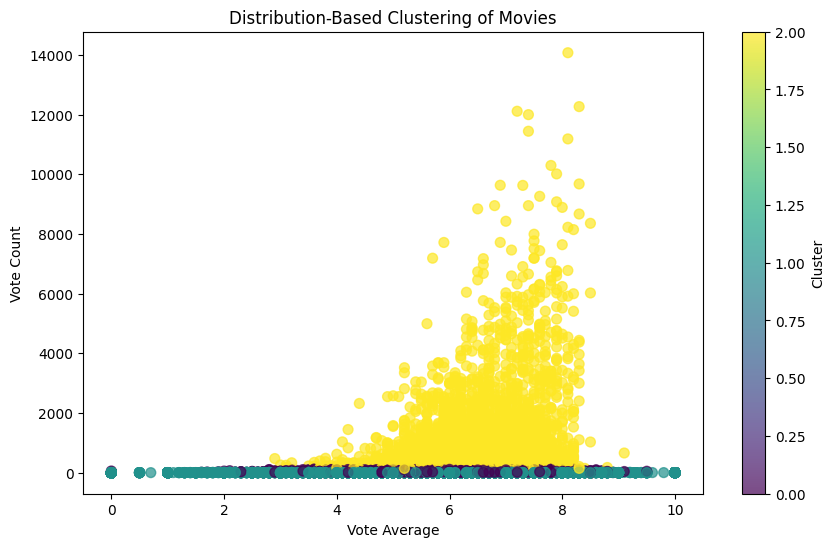

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Filter relevant columns and drop rows with missing values
data = movies_df[['vote_average', 'vote_count']].dropna()

# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=3, random_state=42)  # Assuming 3 clusters, can be adjusted
gmm_labels = gmm.fit_predict(scaled_data)

# Add cluster labels to the original data
data['cluster'] = gmm_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['vote_average'], data['vote_count'], c=data['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("Distribution-Based Clustering of Movies")
plt.xlabel("Vote Average")
plt.ylabel("Vote Count")
plt.colorbar(label='Cluster')
plt.show()


In [11]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import ast

# Ensure 'Cast_parse' is in list format and handle any non-list or NaN entries
movies_df['Cast_parse'] = movies_df['Cast_parse'].apply(lambda x: eval(x) if isinstance(x, str) else x if isinstance(x, list) else [])

# Extract genres and ensure they are in the correct format
def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [genre['name'] for genre in genres]
    except (ValueError, SyntaxError):
        return []

all_genres = set()
movies_df['Genres'].dropna().apply(lambda x: all_genres.update(extract_genres(x)))

all_genres = sorted(list(all_genres))

# Extract the release year from the release_date column
movies_df['Release_Year'] = pd.to_datetime(movies_df['Release_Date'], errors='coerce').dt.year
all_release_years = sorted(movies_df['Release_Year'].dropna().astype(int).unique(), reverse=True)

# Initialize the main window
root = tk.Tk()
root.title("Movie Recommender")

# Define the function to show recommendations based on actor
def show_actor_recommendations():
    actor_name = actor_input.get().strip().lower()
    filtered_movies = movies_df[movies_df['Cast_parse'].apply(lambda cast: any(actor_name == actor.lower().strip() for actor in cast))]
    
    if filtered_movies.empty:
        result_var.set(f"No movies found with actor '{actor_name.title()}'.")
    else:
        filtered_movies_sorted = filtered_movies.sort_values(by='Popularity', ascending=False)
        top_5_filtered_movies = filtered_movies_sorted.head(5)
        
        # Formatting the output
        results = [f"Title: {row['Original_Title']}\nVote Average: {row['Vote_Average']}\nPopularity: {row['Popularity']}\n{'-' * 50}" 
                   for _, row in top_5_filtered_movies.iterrows()]
        result_var.set("\n\n".join(results))

# Add a label and entry for actor name input
ttk.Label(root, text="Enter Actor's Name:").grid(column=0, row=0, padx=10, pady=10)
actor_input = ttk.Entry(root)
actor_input.grid(column=1, row=0, padx=10, pady=10)

# Add a button to trigger actor-based recommendation
ttk.Button(root, text="Find Movies", command=show_actor_recommendations).grid(column=0, row=1, columnspan=2, padx=10, pady=10)

# Add a label to display the results
result_var = tk.StringVar()
result_label = ttk.Label(root, textvariable=result_var, justify='left')
result_label.grid(column=0, row=2, columnspan=2, padx=10, pady=10)

# Run the application
root.mainloop()
